<a href="https://colab.research.google.com/github/WanjikuGithu/Football-ranking-regression-exercise/blob/master/Week6_IP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Fifa World Ranking Dataset: A Regression Exercise**

1. Defining the question

a. Specifying the question

As a football analyst, a task to predict the results of a game between two teams based on who's home and who's away has been allocated to you and you are to use two approaches: Polynomial and Logistic Regression 

b. Defining the metrics for success

The prediction will be deemed successful when we have the following:



*   Exploratory data analysis results
*   Two Polynomial models predicting the number of scores( for home and away teams) and their RMSEs
*   Logistic regression model and its accuracy score



c. Understanding the context

The FIFA ranking system relies on adding/subtracting points won or lost for a game to/from the previous point totals rather than averaging game points over a given time period as in the previous version of the World Ranking.
In our case two datasets have been provided namely: FIFA ranking data and results data. It contains the average points awarded for previous years and home and away scores features.

d. Recording the Experimental Design
The following are the steps taken in the analysis process:


*   Performing the Exploratory Data Analysis
*   Feature engineering through generating new features
*   Checking for multicollinearity
*   Building the models
*   Validating the models by looking at their accuracy metrics





Reading the Data

In [103]:
# Importing the relevant libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
import scipy as sp

from sklearn import linear_model
from sklearn import preprocessing
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV

In [104]:
# Loading the datasets
ranking_df = pd.read_csv('fifa_ranking.csv')
results_df = pd.read_csv('results.csv')

3. Checking the data

In [105]:
# Determining the number of records in our dataset
print(ranking_df.shape)
print(results_df.shape)

(57793, 16)
(40839, 9)


In [106]:
# Previewing the top of our Fifa ranking dataset
ranking_df.head()

,rank,country_full,country_abrv,total_points,previous_points,rank_change,cur_year_avg,cur_year_avg_weighted,last_year_avg,last_year_avg_weighted,two_year_ago_avg,two_year_ago_weighted,three_year_ago_avg,three_year_ago_weighted,confederation,rank_date
0,1,Germany,GER,0.0,57,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,UEFA,1993-08-08
1,2,Italy,ITA,0.0,57,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,UEFA,1993-08-08
2,3,Switzerland,SUI,0.0,50,9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,UEFA,1993-08-08
3,4,Sweden,SWE,0.0,55,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,UEFA,1993-08-08
4,5,Argentina,ARG,0.0,51,5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,CONMEBOL,1993-08-08


In [107]:
# Previewing the bottom of our dataset
ranking_df.tail()

,rank,country_full,country_abrv,total_points,previous_points,rank_change,cur_year_avg,cur_year_avg_weighted,last_year_avg,last_year_avg_weighted,two_year_ago_avg,two_year_ago_weighted,three_year_ago_avg,three_year_ago_weighted,confederation,rank_date
57788,206,Anguilla,AIA,0.0,0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,CONCACAF,2018-06-07
57789,206,Bahamas,BAH,0.0,0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,CONCACAF,2018-06-07
57790,206,Eritrea,ERI,0.0,0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,CAF,2018-06-07
57791,206,Somalia,SOM,0.0,0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,CAF,2018-06-07
57792,206,Tonga,TGA,0.0,0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,OFC,2018-06-07


In [108]:
# Previewing our results dataset
results_df

,date,home_team,away_team,home_score,away_score,tournament,city,country,neutral
0,1872-11-30,Scotland,England,0,0,Friendly,Glasgow,Scotland,False
1,1873-03-08,England,Scotland,4,2,Friendly,London,England,False
2,1874-03-07,Scotland,England,2,1,Friendly,Glasgow,Scotland,False
3,1875-03-06,England,Scotland,2,2,Friendly,London,England,False
4,1876-03-04,Scotland,England,3,0,Friendly,Glasgow,Scotland,False
...,...,...,...,...,...,...,...,...,...
40834,2019-07-18,American Samoa,Tahiti,8,1,Pacific Games,Apia,Samoa,True
40835,2019-07-18,Fiji,Solomon Islands,4,4,Pacific Games,Apia,Samoa,True
40836,2019-07-19,Senegal,Algeria,0,1,African Cup of Nations,Cairo,Egypt,True
40837,2019-07-19,Tajikistan,North Korea,0,1,Intercontinental Cup,Ahmedabad,India,True


In [109]:
# Checking the columns datatypes
print(ranking_df.dtypes)
print(results_df.dtypes)

rank                         int64
country_full                object
country_abrv                object
total_points               float64
previous_points              int64
rank_change                  int64
cur_year_avg               float64
cur_year_avg_weighted      float64
last_year_avg              float64
last_year_avg_weighted     float64
two_year_ago_avg           float64
two_year_ago_weighted      float64
three_year_ago_avg         float64
three_year_ago_weighted    float64
confederation               object
rank_date                   object
dtype: object
date          object
home_team     object
away_team     object
home_score     int64
away_score     int64
tournament    object
city          object
country       object
neutral         bool
dtype: object


4. External Source Validation

The datasets provided, specifically the ranking one matches the ones on the the official FIFA website ([link](https://www.fifa.com/fifa-world-ranking/))



5. Tidying the dataset

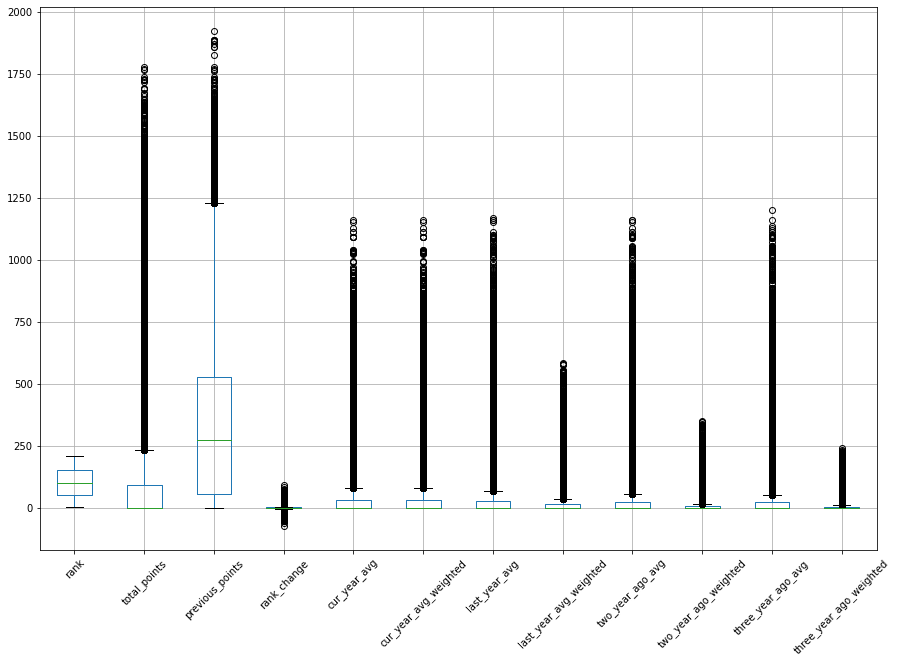

In [110]:
# Checking for outliers in the ranking dataset using a boxplot
ranking_df.boxplot(figsize=(15,10))
plt.xticks(rotation=45)
plt.show()

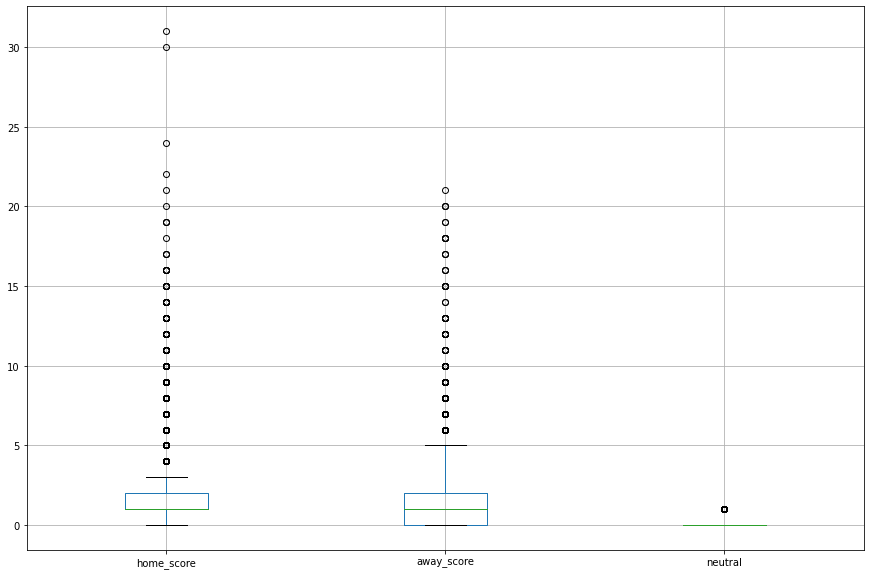

In [111]:
# Checking for outliers in the results dataset
results_df.boxplot(figsize=(15,10))

There are several outliers in the data but we'll work with them as they depict the recorded observations and are therefore viable

In [112]:
# Checking for missing values in the ranking data
ranking_df.isnull().sum()

rank                       0
country_full               0
country_abrv               0
total_points               0
previous_points            0
rank_change                0
cur_year_avg               0
cur_year_avg_weighted      0
last_year_avg              0
last_year_avg_weighted     0
two_year_ago_avg           0
two_year_ago_weighted      0
three_year_ago_avg         0
three_year_ago_weighted    0
confederation              0
rank_date                  0
dtype: int64

In [113]:
# Checking for missing values in the results data
results_df.isnull().sum()

date          0
home_team     0
away_team     0
home_score    0
away_score    0
tournament    0
city          0
country       0
neutral       0
dtype: int64

There are no missing values in the original dataset

In [114]:
# Splitting date column into year and month for the results dataset
print(results_df['date'].unique())
results_df['date'] = results_df['date'].apply(lambda x: x.replace('/', '-'))
results_df['date'] = pd.to_datetime(results_df['date'])
results_df['year'] = results_df['date'].dt.year
results_df['month'] = results_df['date'].dt.month

['1872-11-30' '1873-03-08' '1874-03-07' ... '2019-07-18' '2019-07-19'
 '2019-07-20']


In [115]:
# Splitting date column into year and month for the ranking dataset
ranking_df['rank_date'] = ranking_df['rank_date'].apply(lambda x: x.replace('/', '-'))
ranking_df['rank_date'] = pd.to_datetime(ranking_df['rank_date'])
ranking_df['year'] = ranking_df['rank_date'].dt.year
ranking_df['month'] = ranking_df['rank_date'].dt.month

In [116]:
# Merging the two datasets to get the home team and ranking data
home_ranking_df = pd.merge(ranking_df, results_df, how = 'inner', left_on = ['year', 'month','country_full'], right_on = ['year', 'month','home_team'])
home_ranking_df.head(3)

,rank,country_full,country_abrv,total_points,previous_points,rank_change,cur_year_avg,cur_year_avg_weighted,last_year_avg,last_year_avg_weighted,two_year_ago_avg,two_year_ago_weighted,three_year_ago_avg,three_year_ago_weighted,confederation,rank_date,year,month,date,home_team,away_team,home_score,away_score,tournament,city,country,neutral
0,4,Sweden,SWE,0.0,55,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,UEFA,1993-08-08,1993,8,1993-08-11,Sweden,Switzerland,1,2,Friendly,Borås,Sweden,False
1,4,Sweden,SWE,0.0,55,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,UEFA,1993-08-08,1993,8,1993-08-22,Sweden,France,1,1,FIFA World Cup qualification,Solna,Sweden,False
2,5,Argentina,ARG,0.0,51,5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,CONMEBOL,1993-08-08,1993,8,1993-08-22,Argentina,Peru,2,1,FIFA World Cup qualification,Buenos Aires,Argentina,False


In [117]:
# Merging to get the away ranking data
away_ranking_df = pd.merge(ranking_df, results_df, how = 'inner', left_on = ['year', 'month','country_full'], right_on = ['year', 'month','away_team'])
away_ranking_df.head(3)

,rank,country_full,country_abrv,total_points,previous_points,rank_change,cur_year_avg,cur_year_avg_weighted,last_year_avg,last_year_avg_weighted,two_year_ago_avg,two_year_ago_weighted,three_year_ago_avg,three_year_ago_weighted,confederation,rank_date,year,month,date,home_team,away_team,home_score,away_score,tournament,city,country,neutral
0,3,Switzerland,SUI,0.0,50,9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,UEFA,1993-08-08,1993,8,1993-08-11,Sweden,Switzerland,1,2,Friendly,Borås,Sweden,False
1,5,Argentina,ARG,0.0,51,5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,CONMEBOL,1993-08-08,1993,8,1993-08-01,Peru,Argentina,0,1,FIFA World Cup qualification,Lima,Peru,False
2,5,Argentina,ARG,0.0,51,5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,CONMEBOL,1993-08-08,1993,8,1993-08-08,Paraguay,Argentina,1,3,FIFA World Cup qualification,Asunción,Paraguay,False


In [ ]:
# Picking the columns relevant to our analysis
home_ranking = home_ranking_df[['rank','rank_change','country','home_team','away_team','home_score','away_score','tournament','neutral','month','year','total_points','previous_points']] 
# Renaming the rank to specify it as home rank
home_ranking.rename(columns={'rank':'home_rank'}, inplace=True)

In [ ]:
# Picking the relevant columns in away dataset
away_ranking = away_ranking_df[['rank','away_team','month','year']]

# Renaming the rank to specify it as home rank
away_ranking.rename(columns={'rank':'away_rank'}, inplace=True)

In [120]:
# Final data with the home rank and away rank columns
df = home_away = pd.merge(home_ranking, away_ranking, how = 'inner', left_on = ['year', 'month','away_team'], right_on = ['year', 'month','away_team'])
df.head()

,home_rank,rank_change,country,home_team,away_team,home_score,away_score,tournament,neutral,month,year,total_points,previous_points,away_rank
0,4,0,Sweden,Sweden,Switzerland,1,2,Friendly,False,8,1993,0.0,55,3
1,4,0,Sweden,Sweden,France,1,1,FIFA World Cup qualification,False,8,1993,0.0,55,12
2,5,5,Argentina,Argentina,Peru,2,1,FIFA World Cup qualification,False,8,1993,0.0,51,70
3,5,5,Argentina,Argentina,Peru,2,1,FIFA World Cup qualification,False,8,1993,0.0,51,70
4,5,5,Argentina,Argentina,Peru,2,1,FIFA World Cup qualification,False,8,1993,0.0,51,70


In [121]:
# Check for missing values after the merge
df.isnull().any().sum()

# No missing values

0

6. Exploratory Data Analysis

In [122]:
# Determining the number of records in the merged data
df.shape

(28518, 14)

In [123]:
# Plotting univariate summaries
df.describe()

,home_rank,rank_change,home_score,away_score,month,year,total_points,previous_points,away_rank
count,28518.000000,28518.000000,28518.000000,28518.000000,28518.000000,28518.000000,28518.000000,28518.000000,28518.000000
mean,78.456449,1.104530,1.595589,1.100989,6.723438,2006.196683,157.305015,418.343713,81.480574
std,51.079457,7.034801,1.634277,1.278697,3.361838,6.842606,308.226022,315.813190,52.538276
min,1.000000,-62.000000,0.000000,0.000000,1.000000,1993.000000,0.000000,0.000000,1.000000
25%,35.000000,-2.000000,0.000000,0.000000,4.000000,2000.000000,0.000000,150.000000,38.000000
50%,74.000000,0.000000,1.000000,1.000000,6.000000,2006.000000,0.000000,399.000000,76.000000
75%,114.000000,3.000000,2.000000,2.000000,10.000000,2012.000000,194.557500,595.000000,119.000000
max,209.000000,73.000000,31.000000,15.000000,12.000000,2018.000000,1770.060000,1887.000000,209.000000


In [124]:
# Checking for independence between features using a correlation matrix
df.corr()

,home_rank,rank_change,home_score,away_score,neutral,month,year,total_points,previous_points,away_rank
home_rank,1.000000,-0.003985,-0.115309,0.221202,0.019133,0.068282,0.092840,-0.299011,-0.653222,0.514813
rank_change,-0.003985,1.000000,0.078472,-0.074240,0.013530,0.053138,-0.075539,-0.061237,-0.118316,0.040974
home_score,-0.115309,0.078472,1.000000,-0.160963,-0.051272,0.019208,-0.052746,0.012116,0.069722,0.307034
away_score,0.221202,-0.074240,-0.160963,1.000000,0.128605,0.019761,-0.012682,-0.062368,-0.130786,-0.151864
neutral,0.019133,0.013530,-0.051272,0.128605,1.000000,-0.087394,0.038912,0.048939,0.016315,0.032648
month,0.068282,0.053138,0.019208,0.019761,-0.087394,1.000000,-0.007457,0.010915,-0.069358,0.068660
year,0.092840,-0.075539,-0.052746,-0.012682,0.038912,-0.007457,1.000000,0.624476,0.407829,0.092347
total_points,-0.299011,-0.061237,0.012116,-0.062368,0.048939,0.010915,0.624476,1.000000,0.546566,-0.146631
previous_points,-0.653222,-0.118316,0.069722,-0.130786,0.016315,-0.069358,0.407829,0.546566,1.000000,-0.310698
away_rank,0.514813,0.040974,0.307034,-0.151864,0.032648,0.068660,0.092347,-0.146631,-0.310698,1.000000


7. Implementing the Solution

**Polynomial Regression: The First Approach**

In this approach, we train:


*   Rank of home team
*   Rank of away team
*   Tournament type

Using two models to predict:


*   How many goals the home team scores
*   How many goals the away team scores












In [125]:
# Creating the tournament column into types(world cup, friendly or other)
poly_data = df.copy()
def tournament_type(a):
    if a == 'Friendly':
        return 'Friendly'
    elif a == 'FIFA World Cup':
        return 'World cup'
    else:
        return 'Other'
      
poly_data['tournament_type'] = poly_data['tournament'].apply(lambda t: tournament_type(t))
poly_data['tournament_type'].value_counts()

Other        17796
Friendly     10326
World cup      396
Name: tournament_type, dtype: int64

In [126]:
# Specifying the columns to use in the modelling process
poly_data.drop(['country', 'home_team', 'away_team', 'tournament', 'month', 'year'], axis=1, inplace=True)

In [127]:
# Initialising the label encoder to tranform the neutral and tournament type columns to numerical format
label_encoder = preprocessing.LabelEncoder() 
poly_data['neutral']= label_encoder.fit_transform(poly_data['neutral']) 
print(poly_data['neutral'].unique())
poly_data['tournament_type']= label_encoder.fit_transform(poly_data['tournament_type']) 
print(poly_data['tournament_type'].unique()) 

[0 1]
[0 1 2]


Using Polynomial Regression to Predict the Home Team Scores: The First Model

An issue with multivariate polynomial regression is multicollinearity which is the interdependence between predictors that restricts the model from properly fitting the dataset.

In [128]:
# Using VIF to check for multicollinearity
def calc_vif(a):

    # Calculating VIF
    vif = pd.DataFrame()
    vif["variables"] = a.columns
    vif["VIF"] = [variance_inflation_factor(a.values, i) for i in range(a.shape[1])]

    return(vif)

In [129]:
# Defining the features and target variable
X = poly_data.drop(['home_score'], axis=1)
y = poly_data['home_score']

In [130]:
a = X
calc_vif(a)

,variables,VIF
0,home_rank,5.481928
1,rank_change,1.047260
2,away_score,2.028386
3,neutral,1.582259
4,total_points,1.779042
5,previous_points,2.884468
6,away_rank,4.977390
7,tournament_type,2.647529


VIF value exceeding 5 indicates high multicollinearity between the variable and others.

Assumption: Although the definition of the problem required us to use the ranks and tournament type to train our model, we assume the home rank will have a high effect on the model due to its high VIF therefore we drop it 

In [131]:
# Dropping the home rank to see if the VIF values improve
X = X.drop(['home_rank'], axis=1)
calc_vif(X)

,variables,VIF
0,rank_change,1.046686
1,away_score,1.544899
2,neutral,1.582148
3,total_points,1.779023
4,previous_points,2.710701
5,away_rank,2.122137
6,tournament_type,2.552211


The VIF values have significantly dropped, we now move to the modelling

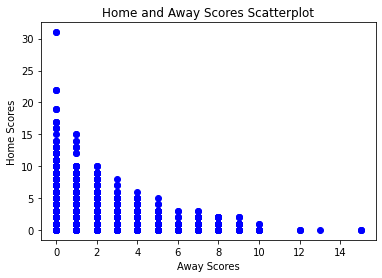

In [132]:
# Visualising the relationship between the home and away scores
plt.scatter(X['away_score'], y, c='blue')
plt.title('Home and Away Scores Scatterplot')
plt.xlabel('Away Scores')
plt.ylabel('Home Scores')
plt.show()

In [133]:
# Splitting the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .3, random_state=25)

In [134]:
# Fitting a Polynomial Regression to the dataset
poly_reg = PolynomialFeatures(degree = 2) 
X_poly = poly_reg.fit_transform(X)

In [135]:
X_train = poly_reg.fit_transform(X_train)
X_test = poly_reg.fit_transform(X_test)

In [136]:
# Training the model
pol_reg = LinearRegression()
pol_reg.fit(X_train, y_train)

# Running the prediction
y_pred = pol_reg.predict(X_test)
y_pred

# Calculating the RMSE
print("The RMSE score for the model : ", np.sqrt(metrics.mean_squared_error(y_test, y_pred)))


The RMSE score for the model :  1.4363927584533813


Checking for heteroskedasticity using Bartlett's test

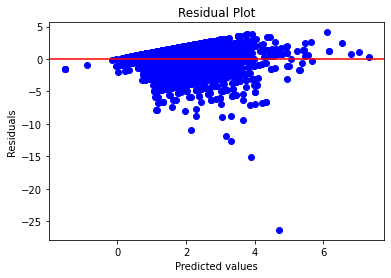

In [137]:
# Plotting the residuals
residuals = y_pred - y_test
plt.scatter(y_pred, residuals, c='blue')
plt.title('Residual Plot')
plt.xlabel('Predicted values')
plt.ylabel('Residuals')
plt.axhline(y= residuals.mean(), color='red')
plt.show()

Heteroscedasticity means unequal scatter. The residual plot above has a slight cone shape towards the right which might indicate heteroscedasticity but let's test for this using Bartlett's test to be sure

In [138]:
#Using Bartlett's test
test_result, p_value = sp.stats.bartlett(y_pred, residuals)

# To interpret the results we must also compute a critical value of the chi squared distribution
degree_of_freedom = len(y_pred)-1
probability = 1 - p_value

critical_value = sp.stats.chi2.ppf(probability, degree_of_freedom)


# If the test_result is greater than the critical value, then we reject our null
# hypothesis. This would mean that there are patterns to the variance of the data

# Otherwise, we can identify no patterns, and we accept the null hypothesis that 
# the variance is homogeneous across our data

if (test_result > critical_value):
  print('the variances are unequal, and the model should be reassessed')
else:
  print('the variances are homogeneous!')


the variances are homogeneous!


Our variances have a uniform scatter and there's no need to reassess the model

Using Polynomial Regression to Predict the Away Team Scores: The Second Model

In [139]:
# Defining the features and target variable
X = poly_data.drop(['away_score'], axis=1)
y = poly_data['away_score']

In [140]:
# Splitting the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .3, random_state=25)

In [141]:
# Fitting a Polynomial Regression to the dataset
poly_reg = PolynomialFeatures(degree = 2) 
X_poly = poly_reg.fit_transform(X)

In [142]:
X_train = poly_reg.fit_transform(X_train)
X_test = poly_reg.fit_transform(X_test)

In [143]:
# Training the model
pol_reg = LinearRegression()
pol_reg.fit(X_train, y_train)

# Running the prediction
y_pred = pol_reg.predict(X_test)
y_pred

# Calculating the RMSE
print("The RMSE score for the model : ", np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

The RMSE score for the model :  1.1505712903171184


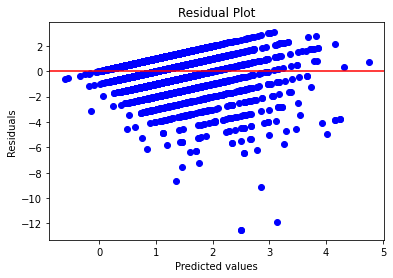

In [144]:
# Plotting the residuals
residuals = y_pred - y_test
plt.scatter(y_pred, residuals, c='blue')
plt.title('Residual Plot')
plt.xlabel('Predicted values')
plt.ylabel('Residuals')
plt.axhline(y= residuals.mean(), color='red')
plt.show()

In [145]:
#Using Bartlett's test
test_result, p_value = sp.stats.bartlett(y_pred, residuals)

# To interpret the results we must also compute a critical value of the chi squared distribution
degree_of_freedom = len(y_pred)-1
probability = 1 - p_value

critical_value = sp.stats.chi2.ppf(probability, degree_of_freedom)


# If the test_result is greater than the critical value, then we reject our null
# hypothesis. This would mean that there are patterns to the variance of the data

# Otherwise, we can identify no patterns, and we accept the null hypothesis that 
# the variance is homogeneous across our data

if (test_result > critical_value):
  print('the variances are unequal, and the model should be reassessed')
else:
  print('the variances are homogeneous!')

the variances are homogeneous!


The RMSE of model 2 is smaller than that of model 1. The pattern of the residual plot should be further investigated to see what is contributing to it, whether a variable is influencing it or not.

**Logistic Regression: The Second Approach**



Using feature Engineering to figure out from the home's perspective if the game is a  win, lose or draw

In [146]:
# Creating a new column in our data
df['home_away_difference'] = df['home_score'] - df['away_score']
df.head(3)

,home_rank,rank_change,country,home_team,away_team,home_score,away_score,tournament,neutral,month,year,total_points,previous_points,away_rank,home_away_difference
0,4,0,Sweden,Sweden,Switzerland,1,2,Friendly,False,8,1993,0.0,55,3,-1
1,4,0,Sweden,Sweden,France,1,1,FIFA World Cup qualification,False,8,1993,0.0,55,12,0
2,5,5,Argentina,Argentina,Peru,2,1,FIFA World Cup qualification,False,8,1993,0.0,51,70,1


In [147]:
# Using the difference to determine the status of the game
def status_determiner(home_scores):
    if home_scores > 0:
        return 'Win'
    elif home_scores < 0:
        return 'Lose'
    else:
        return 'Draw'
      
df['status'] = df['home_away_difference'].apply(lambda h: status_determiner(h))

Building a Multinomial Logistic Regression model

Assumption: Some of the variables in the whole dataset have no effect on our target therefore they are not relevant in the prediction and they need to be dropped

In [148]:
# Dropping the columns that will not be used in the model
model_data = df.copy()
model_data.drop(['country', 'home_team', 'away_team', 'month', 'year', 'home_away_difference', 'tournament'], axis=1, inplace=True)

In [149]:
# Initialising the label encoder to tranform the status column to numerical format
label_encoder = preprocessing.LabelEncoder() 
model_data['status']= label_encoder.fit_transform(model_data['status']) 
model_data['status'].unique() 

array([1, 0, 2])

In [150]:
# Splitting the dataset into train and test sets
X = model_data.drop(['status'], axis=1)
y = model_data[['status']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .3, random_state=25)

In [ ]:
# Fitting our Logistic Regression Model
LogReg = LogisticRegression()
LogReg.fit(X_train, y_train)

In [152]:
# Using our model to make a prediction
y_pred = LogReg.predict(X_test)
y_pred

array([2, 2, 1, ..., 1, 2, 2], dtype=int64)

In [153]:
# Evaluating the model using the confusion matrix
confusion_matrix = confusion_matrix(y_test, y_pred)
confusion_matrix

array([[1314,  281,  394],
       [ 390, 2031,    5],
       [ 235,    4, 3902]])

The results from the confusion matrix tell us that 1314, 2031 and 3902 are the number of correct predictions.


In [154]:
# Calculating the accuracy of our model
# Computing from the confusion matrix which is:TP+TN/Total number of classified items
accuracy_status= (1314+2031+3902)/len(y_pred)
print(accuracy_status)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(LogReg.score(X_test, y_test)))

0.8470079476390837
Accuracy of logistic regression classifier on test set: 0.85


Our accuracy from both the confusion matrix and from sklearn accuracy score are similar

8. Challenging the Solution

In [155]:
# Can we can improve our model through hyperparameter tuning
# Creating the logistic regression
logistic = linear_model.LogisticRegression()

In [156]:
# Creating regularization penalty space
penalty = ['l1', 'l2']
penalty
# Creating regularization hyperparameter space
C = np.logspace(0, 4, 10)
C

# Creating hyperparameter options
hyperparameters = dict(C=C, penalty=penalty)
hyperparameters

{'C': array([1.00000000e+00, 2.78255940e+00, 7.74263683e+00, 2.15443469e+01,
        5.99484250e+01, 1.66810054e+02, 4.64158883e+02, 1.29154967e+03,
        3.59381366e+03, 1.00000000e+04]), 'penalty': ['l1', 'l2']}

In [157]:
# Creating grid search using 5-fold cross validation
grid = GridSearchCV(logistic, hyperparameters, cv=5, verbose=0)

In [ ]:
# Fitting grid search
best_model = grid.fit(X, y)
best_model

In [160]:
# Vieweing our cv results in a dataframe
grid.cv_results_
grid_df = pd.DataFrame(grid.cv_results_)
grid_df.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_penalty,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.004750,0.000232,0.000000,0.000000,1,l1,"{'C': 1.0, 'penalty': 'l1'}",NaN,NaN,NaN,NaN,NaN,NaN,NaN,20
1,1.258876,0.019457,0.006222,0.000159,1,l2,"{'C': 1.0, 'penalty': 'l2'}",0.819074,0.833450,0.826964,0.827985,0.849027,0.831300,0.009981,5
2,0.004106,0.000196,0.000000,0.000000,2.78256,l1,"{'C': 2.7825594022071245, 'penalty': 'l1'}",NaN,NaN,NaN,NaN,NaN,NaN,NaN,19
3,1.273068,0.027417,0.006246,0.000299,2.78256,l2,"{'C': 2.7825594022071245, 'penalty': 'l2'}",0.815919,0.834502,0.821529,0.829739,0.844468,0.829231,0.009967,9
4,0.003904,0.000168,0.000000,0.000000,7.74264,l1,"{'C': 7.742636826811269, 'penalty': 'l1'}",NaN,NaN,NaN,NaN,NaN,NaN,NaN,12


In [159]:
# Viewing best hyperparameters
print('Best Penalty:', best_model.best_estimator_.get_params()['penalty'])
print('Best C:', best_model.best_estimator_.get_params()['C'])

Best Penalty: l2
Best C: 21.544346900318832


In [ ]:
# Fitting our model again with the best parameters to see if there'll be a change
LogReg = LogisticRegression(penalty='l2', C=21.5)
LogReg.fit(X_train, y_train)

# Running the prediction
y_pred = LogReg.predict(X_test)
y_pred


In [162]:
# Viewing our accuracy
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(LogReg.score(X_test, y_test)))

Accuracy of logistic regression classifier on test set: 0.86


Running our model with different parameters slightly improves its accuracy as it improved from 0.85% to 0.86%

9. Follow Up Questions

Did we have the right data? And was it enough to answer the question

Yes, we had the right data and we asked the right questions. Our success metrics were met and maybe other algorithms could be implemented to see if there will be an improvement in performance of the models.